### Crop Windows
--> windows around annotated cells

--> windows around all from stardist detected cells

--> random crops that DO NOT contain apoptotic cells but can contain healthy cells

In [15]:
### Imports
# Standard library imports
import json
import os
import shutil
import logging
import sys

# Third-party imports
# Data handling
import numpy as np
import pandas as pd

# Image I/O and processing
import tifffile as tiff
from nd2reader import ND2Reader
from skimage.morphology import remove_small_objects

# Tracking
import btrack
from btrack.constants import BayesianUpdates

# Visualization
import matplotlib.cm as cm
import matplotlib.pyplot as plt

# Utilities
from tqdm import tqdm

from datetime import datetime


# from typing import Tuple, Union

In [16]:
## Variables
## Directory Paths
# Input
IMG_DIR = '/mnt/imaging.data/PertzLab/apoDetection/TIFFs'
APO_DIR = '/mnt/imaging.data/PertzLab/apoDetection/ApoptosisAnnotation'
EXPERIMENT_INFO = '/mnt/imaging.data/PertzLab/apoDetection/List of the experiments.csv'
CSV_DIR = '../data/apo_match_csv_test'    # File with manual and stardist centroids
TRACKED_MASK_DIR = '../data/tracked_masks'
TRACK_DF_DIR = '../data/track_dfs'


# Output
MASK_DIR = '../data/apo_masks'    # Stardist label predictions
DF_DIR = '../data/summary_dfs'
CROPS_DIR = '../data/apo_crops_test'    # Directory with .tif files for QC
WINDOWS_DIR = '/home/nbahou/myimaging/apoDet/data/windows_test'    # Directory with crops for scDINO
RANDOM_DIR = os.path.join(WINDOWS_DIR, 'random')
#CLASS_DCT_PATH = './extras/class_dicts'


## Processing Configuration
COMPARE_2D_VERS = True
SAVE_MASKS = True
LOAD_MASKS = True
USE_GPU = True
MIN_NUC_SIZE = 200

## Tracking Parameters
BT_CONFIG_FILE = "extras/cell_config.json"  # Path to btrack config file
EPS_TRACK = 70         # Tracking radius [px]
TRK_MIN_LEN = 25       # Minimum track length [frames]

#
MAX_TRACKING_DURATION = 20    # In minutes
FRAME_INTERVAL = 5    # minutes between images we want

WINDOW_SIZE = 61


## Logger Set Up
#logging.shutdown()    # For jupyter notebooks
logger = logging.getLogger(__name__)
#if logger.hasHandlers():
#    logger.handlers.clear()
# Get the current timestamp
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Define log directory and ensure it exists
log_dir = "./logs"  # Folder for logs
os.makedirs(log_dir, exist_ok=True)  # Create directory if it doesn't exist

log_filename = f"crop_windows_{timestamp}.log"
log_path = os.path.join(log_dir, log_filename)

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(log_path),
        logging.StreamHandler(sys.stdout)  # Outputs to console too
    ],
    force = True
)

# Create a logger instance
logger = logging.getLogger(__name__)

# Only forward Warnings/Errors/Critical from btrack
logging.getLogger('btrack').setLevel(logging.WARNING)


In [17]:
def load_image_stack(path):
    """
    Load an image stack from a file based on its extension.
    
    Uses tifffile for TIFF files and ND2Reader for ND2 files.
    """
    if path.endswith(('.tif', '.tiff')):
        # Load TIFF file using tifffile
        return tiff.imread(path)
    elif path.endswith('.nd2'):
        # Load ND2 file using ND2Reader and convert it to a numpy array
        with ND2Reader(path) as nd2:
            return np.array(nd2)
    else:
        raise ValueError(f"Unsupported file format for file: {path}")

def get_image_paths(directory):
    """
    Returns a list of absolute paths of all TIFF and ND2 files in a directory.
    """
    valid_extensions = ('.tif', '.tiff', '.nd2')
    paths = [
        os.path.abspath(os.path.join(directory, f))
        for f in os.listdir(directory)
        if f.endswith(valid_extensions)
    ]
    return sorted(paths)

def crop_window(img, center_x, center_y, window_size):
    # Check if number is even, add one if so
    if window_size%2 == 0:
        window_size += 1
    half_window_size = window_size // 2
    x_from = max(center_x - half_window_size, 0)
    x_to = min(center_x + half_window_size + 1, img.shape[1])
    y_from = max(center_y - half_window_size, 0)
    y_to = min(center_y + half_window_size + 1, img.shape[0])
    window = img[y_from:y_to, x_from:x_to]

    return window


def check_temporal_compatibility(
        filename: str,
        experiments_df: pd.DataFrame,
        target_interval: int
    ) -> tuple[bool, str | int]:
    """Check compatibility between acquisition frequency and target interval.
    
    Returns:
        tuple: (is_valid: bool, result: str|int)
        - If valid: (True, acquisition_freq: int)
        - If invalid: (False, error_message: str)
    """
    experiment_id = filename.split('_')[0]
    matching_row = experiments_df[experiments_df['Experiment'] == experiment_id]

    if matching_row.empty:
        return False, f"Experiment {experiment_id} not found in registry"
    
    try:
        acquisition_freq = int(matching_row['Acquisition_frequency(min)'].iloc[0])
    except (ValueError, TypeError):
        return False, f"Invalid frequency format in registry (file: {filename})"
    
    # Combined validation checks
    if acquisition_freq <= 0:
        return False, f"Invalid acquisition frequency: {acquisition_freq} (file: {filename})"
    if target_interval % acquisition_freq != 0:
        return False, f"{target_interval}min target not divisible by {acquisition_freq}min acquisition (file: {filename})"

    return True, acquisition_freq

In [18]:
# Load image paths in specified directory
logger.info("Starting Image Processing")
image_paths = get_image_paths(os.path.join(IMG_DIR))
filenames = [os.path.splitext(os.path.basename(path))[0] for path in image_paths[:2]]    ### TODO remove :2 here, was only for testing
logger.info(f"Detected {len(filenames)} files in specified directories.")
#print(filenames)

# Create directories for saving if they do not exist
output_dirs = [CSV_DIR, MASK_DIR, DF_DIR, CROPS_DIR, WINDOWS_DIR]
for path in output_dirs:
    os.makedirs(path, exist_ok=True)
    

# Frame rate and movie length for crops
try:
    experiments_list = pd.read_csv(EXPERIMENT_INFO, header=0)
except FileNotFoundError as e:
    logger.critical(f"Critical error: experiment list file not found: {EXPERIMENT_INFO}. Aborting script.")
    sys.exit(1)
num_timepoints = MAX_TRACKING_DURATION // FRAME_INTERVAL    # eg 20mins/5min = 4 images. 

## Lists and counters for evaluation of the matching and cropping process
# initalize a list to investigate track lengths after apoptosis
survival_times = []


# Loop over all files in target directory (predict labels, track and crop windows for each)
logger.info("Starting to process files.")
for path, filename in zip(image_paths, filenames):
    logger.info(f"Processing {filename}")

    try:
        merge_df_path = os.path.join(TRACK_DF_DIR, f"{filename}.csv")
        merged_df = pd.read_csv(merge_df_path)
        merged_df_long = merged_df[merged_df.groupby("track_id")["track_id"].transform('size') >= TRK_MIN_LEN].copy()
    except:
        logger.warning(f"\tSkipping {filename} due to: {str(e)}. DF with track_ids and centroids not found.")
        continue 
    
    try:
        csv_path = os.path.join(CSV_DIR, f'{filename}.csv')
        apo_annotations = pd.read_csv(csv_path)
    except Exception as e:
        logger.warning(f"\tSkipping {filename} due to: {str(e)}. Annotations of apoptotic cells not found.")
        continue 

    # Load mask with track_ids
    mask_path = os.path.join(TRACKED_MASK_DIR, f'{filename}.npz')
    loaded_data = np.load(mask_path)
    tracked_masks = loaded_data['gt']


    is_valid, result = check_temporal_compatibility(filename, experiments_list, FRAME_INTERVAL)
    print(f"Valid Stack = {is_valid}: acq_freq = {result}")

    # Skip current file if it is not compatible temporally
    if not is_valid:
        logger.warning(f"\t{result}")
        continue

    # Vars for window cropping
    acquisition_freq = result
    step = FRAME_INTERVAL // acquisition_freq    # e.g. 5 // 1 = 1 image every 5 frames
    num_frames = MAX_TRACKING_DURATION // acquisition_freq
    target_size = WINDOW_SIZE if WINDOW_SIZE%2 != 0 else WINDOW_SIZE + 1    # Adds + 1 if even to have the annotated pixel centered in the window

    logger.debug(f"\tTime Info:")
    logger.debug(f"\t\t File Interval: {acquisition_freq} min/image")
    logger.debug(f"\t\tTarget Interval: {FRAME_INTERVAL} min/img")
    logger.debug(f"\t\tStep Size: {step}")
    logger.debug(f"\t\t Imgs in Crops: {num_timepoints} -> +1 for t0")

    # Create directory for cropped windows
    os.makedirs(os.path.join(CROPS_DIR, filename), exist_ok=True)
    os.makedirs(os.path.join(WINDOWS_DIR, 'apo'), exist_ok=True)
    os.makedirs(os.path.join(CROPS_DIR, f'no_apo_{filename}'), exist_ok=True)
    os.makedirs(os.path.join(WINDOWS_DIR, 'no_apo'), exist_ok=True)
    os.makedirs(os.path.join(CROPS_DIR, f'random_{filename}'), exist_ok=True)
    os.makedirs(os.path.join(WINDOWS_DIR, 'random'), exist_ok=True)


    # Load images to extract windows
    imgs = load_image_stack(os.path.join(IMG_DIR, f'{filename}.tif'))
    
    # Counter so we can sample same number of random tracks as apoptotic
    num_apo_crops = 0 

    # Initialize column apoptotic with zeros
    merged_df_long['apoptotic'] = 0
    
    apo_track_ids = pd.DataFrame(columns=['track_id', 'apo_start_t'])

    logger.info("\tStarting cropping for apo cells")
    for i, row in tqdm(apo_annotations.iterrows(), total=len(apo_annotations), desc="Processing Annotations"):
        current_track_id = row.loc['matching_track']
        current_t = row.loc['t'] + row.loc['delta_ts']

        apo_track_ids.loc[i, 'track_id'] = current_track_id
        apo_track_ids.loc[i, 'apo_start_t'] = current_t

        #current_track_id = current_track_id.squeeze()
        if not np.isscalar(current_track_id):
            current_track_id = current_track_id.iloc[0]

        
        single_cell_df = merged_df_long.loc[(merged_df_long['track_id'] == current_track_id) & (merged_df_long['t'] >= current_t)]
        if len(single_cell_df) < num_frames + 1:
            logger.warning(f"\t\tSkipping current track: {current_track_id}. Reason: Track lost too quickly after anno. len = {len(single_cell_df)}")
            continue
        
        # Count track length after manual apoptosis annotation (for histogram later)
        num_entries = single_cell_df.shape[0]
        survival_times.append(num_entries)

        # merged_df_long.loc[single_cell_df.index, 'apoptotic'] = 1
        merged_df_long.loc[(merged_df_long['track_id'] == current_track_id) & (merged_df_long['t'] >= current_t), 'apoptotic'] = 1
        single_cell_df = single_cell_df.loc[single_cell_df['t'] < current_t + num_frames + step]
        
        
        windows = []
        for _, sc_row in single_cell_df.iterrows():
            window = crop_window(imgs[int(sc_row['t'])], int(sc_row['x']), int(sc_row['y']), WINDOW_SIZE)
            if window.shape == (target_size, target_size):    ### This is a bit dangerous! can mess up time if we simply leave a window out
                windows.append(window)
            else:
                windows.append(None)


        chosen_offset = None
        for offset in range(step):
            sub_windows = windows[offset::step]
            if all(x is not None for x in sub_windows):  
                chosen_offset = offset
                break  # Stop as soon as a valid sequence is found

        if chosen_offset is None:
            logger.warning("\t\tNo valid start point for a sequence with correct intervals found.")
        else:
            sub_windows = windows[chosen_offset::step]
            sub_windows = np.asarray(sub_windows)
            if len(sub_windows) == (MAX_TRACKING_DURATION // step) + 1:
                tiff.imwrite(os.path.join(CROPS_DIR, filename, f'trackID_{current_track_id}.tif'), sub_windows)
                tiff.imwrite(os.path.join(WINDOWS_DIR, 'apo', f'apo_{filename}_{i}.tif'), sub_windows)
                num_apo_crops += 1
            else:
                logger.warning(f'\t\tAt least one of the images has the wrong size after cropping and could not be used. Length = {len(windows)}. Pos = {sc_row["x"]}, {sc_row["y"]}.')
    logger.info(f"\t\tValid crops of apo cells found for {num_apo_crops}/{len(apo_annotations)}")

    num_random_tracks = num_apo_crops
    
    logger.info('\tStarting cropping for non-apo cells.')
    # Get crops of healthy cells
    long_no_apo_df = merged_df_long[merged_df_long['apoptotic'] == 0]
    unique_track_ids = np.unique(long_no_apo_df['track_id'])

    num_healthy_crops = 0
    rejected_windows = 0

    for i, track_id in tqdm(enumerate(unique_track_ids), total=len(unique_track_ids), desc="Cropping non-apo Windows"):
        single_cell_df = long_no_apo_df.loc[long_no_apo_df['track_id'] == track_id]
        start_t = min(single_cell_df['t'])
        # same length as for apoptotic cells
        single_cell_df = single_cell_df.loc[single_cell_df['t'] <= start_t + num_frames]
        windows = []
        for _, sc_row in single_cell_df.iterrows():
            window = crop_window(imgs[int(sc_row['t'])], int(sc_row['x']), int(sc_row['y']), WINDOW_SIZE)
            if window.shape == (target_size, target_size):    ### This is a bit dangerous! can mess up time if we simply leave a window out
                windows.append(window)

        if len(windows) == (MAX_TRACKING_DURATION) + 1:
            windows = np.asarray(windows)
            tiff.imwrite(os.path.join(CROPS_DIR, f'no_apo_{filename}', f'trackID_{track_id}.tif'), windows[::step])
            tiff.imwrite(os.path.join(WINDOWS_DIR, 'no_apo', f'no_apo_{filename}_{i}.tif'), windows[::step])
            num_healthy_crops += 1
        else:
            rejected_windows += 1

            logger.debug(f'\t\tAt least one of the images has the wrong size. Length = {len(windows)}. Pos = {sc_row["x"]}, {sc_row["y"]}.')
    logger.info(f"\t\tFound {num_healthy_crops} valid crops of healthy cells.")
    if rejected_windows > 0:
        logger.warning(f"\t\t{rejected_windows} windows were rejected due to incorrect size.")
    
    # Gather random crops 
    ### I think this could be problematic, oftentimes is full of cells so not really background or negative
    logger.info(f'\tStarting cropping for {num_random_tracks} random locations.')

    # Assuming imgs is a list/array of your image frames,
    # and each image has dimensions: img_height x img_width
    img_height, img_width = imgs[0].shape

    iter_count = 0
    crop_count = 0
    while (crop_count <= num_random_tracks) and (iter_count <= 100):    # Iter count only to stop runaway code
    # for track in range(num_random_tracks):
        # Randomly choose a start time such that the track fits in your image sequence
        start_t = np.random.randint(0, len(imgs) - num_frames)
        
        # Randomly generate valid (x, y) coordinates for the crop center
        random_x = np.random.randint(WINDOW_SIZE//2, img_width - WINDOW_SIZE//2)
        random_y = np.random.randint(WINDOW_SIZE//2, img_height - WINDOW_SIZE//2)
        
        windows = []
        # Extract a window for each frame in the track duration
        for t in range(start_t, start_t + num_frames + 1, step):
            window = crop_window(imgs[t], random_x, random_y, WINDOW_SIZE)
            track_id_mask_crop = crop_window(tracked_masks[t], random_x, random_y, WINDOW_SIZE)
            present_track_ids = track_id_mask_crop.flatten().tolist()
            

            ### Continue here
            current_apo_track_ids = apo_track_ids.loc[apo_track_ids['apo_start_t'] <= t]
            current_apo_ids = set(current_apo_track_ids['track_id'])

            
            if not any(pixel in current_apo_ids for pixel in present_track_ids) and (window.shape == (target_size, target_size)):
                windows.append(window)
            else:
                logger.warning("\t\tCurrent window contains an apoptotic cell or the shape is not matching the target size.")

    
        if len(windows) == (MAX_TRACKING_DURATION//FRAME_INTERVAL) + 1:
            windows = np.asarray(windows)
            tiff.imwrite(os.path.join(CROPS_DIR, f'random_{filename}', f'ID_{crop_count}.tif'), windows)
            tiff.imwrite(os.path.join(WINDOWS_DIR, 'random', f'random_{filename}_{crop_count}.tif'), windows)
            crop_count += 1
            iter_count += 1
        else:
            logger.warning(f'\t\tUnable to collect the desired number of images. Length windows = {len(windows)}')
            iter_count += 1

    logger.info(f"Finished processing {filename}: apo ({num_apo_crops}), healthy ({num_healthy_crops}), random ({num_random_tracks})")



2025-03-20 16:02:01,349 - __main__ - INFO - Starting Image Processing
2025-03-20 16:02:01,352 - __main__ - INFO - Detected 2 files in specified directories.
2025-03-20 16:02:01,356 - __main__ - INFO - Starting to process files.
2025-03-20 16:02:01,358 - __main__ - INFO - Processing Exp01_Site01
Valid Stack = True: acq_freq = 1
2025-03-20 16:02:05,862 - __main__ - INFO - 	Starting cropping for apo cells


Processing Annotations:   0%|                                                                    | 0/51 [00:00<?, ?it/s]

2025-03-20 16:02:05,954 - __main__ - WARNING - 		Skipping current track: 470. Reason: Track lost too quickly after anno. len = 2


Processing Annotations:  16%|█████████▍                                                  | 8/51 [00:00<00:00, 77.87it/s]

2025-03-20 16:02:05,983 - __main__ - WARNING - 		No valid start point for a sequence with correct intervals found.
2025-03-20 16:02:06,024 - __main__ - WARNING - 		No valid start point for a sequence with correct intervals found.


Processing Annotations:  35%|████████████████████▊                                      | 18/51 [00:00<00:00, 86.72it/s]

2025-03-20 16:02:06,152 - __main__ - WARNING - 		No valid start point for a sequence with correct intervals found.


Processing Annotations: 100%|███████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 82.62it/s]

2025-03-20 16:02:06,481 - __main__ - INFO - 		Valid crops of apo cells found for 47/51
2025-03-20 16:02:06,482 - __main__ - INFO - 	Starting cropping for non-apo cells.



Cropping non-apo Windows: 100%|████████████████████████████████████████████████████| 1115/1115 [00:07<00:00, 156.60it/s]

2025-03-20 16:02:13,633 - __main__ - INFO - 		Found 609 valid crops of healthy cells.
2025-03-20 16:02:13,633 - __main__ - WARNING - 		506 windows were rejected due to incorrect size.
2025-03-20 16:02:13,634 - __main__ - INFO - 	Starting cropping for 47 random locations.


2025-03-20 16:02:13,725 - __main__ - WARNING - 		Current window contains an apoptotic cell or the shape is not matching the target size.
2025-03-20 16:02:13,726 - __main__ - WARNING - 		Current window contains an apoptotic cell or the shape is not matching the target size.
2025-03-20 16:02:13,728 - __main__ - WARNING - 		Unable to collect the desired number of images. Length windows = 3
2025-03-20 16:02:13,827 - __main__ - WARNING - 		Current window contains an apoptotic cell or the shape is not matching the target size.
2025-03-20 16:02:13,827 - __main__ - WARNING - 		Unable to collect the desired number of images. Length windows = 4
2025-03-20 16:02:14,083 - __main__ - WARNING - 		Current window contains an apoptotic cell or the shape is not matching the target size.
2025-03-20 16:02:14,083 - __main__ - WARNING - 		Current window contains an apoptotic cell or the shape is not matching the target size.
2025-03-20 16:02:14,084 - __main__ - WARNING - 		Current window contains an apoptot

Processing Annotations:   0%|                                                                    | 0/38 [00:00<?, ?it/s]

2025-03-20 16:02:18,786 - __main__ - WARNING - 		No valid start point for a sequence with correct intervals found.
2025-03-20 16:02:18,788 - __main__ - WARNING - 		Skipping current track: 246. Reason: Track lost too quickly after anno. len = 18
2025-03-20 16:02:18,818 - __main__ - WARNING - 		No valid start point for a sequence with correct intervals found.


Processing Annotations:  24%|██████████████▏                                             | 9/38 [00:00<00:00, 88.12it/s]

2025-03-20 16:02:18,885 - __main__ - WARNING - 		No valid start point for a sequence with correct intervals found.
2025-03-20 16:02:18,889 - __main__ - WARNING - 		No valid start point for a sequence with correct intervals found.
2025-03-20 16:02:18,902 - __main__ - WARNING - 		Skipping current track: 1372. Reason: Track lost too quickly after anno. len = 11
2025-03-20 16:02:18,916 - __main__ - WARNING - 		Skipping current track: 223. Reason: Track lost too quickly after anno. len = 12
2025-03-20 16:02:18,929 - __main__ - WARNING - 		Skipping current track: 58. Reason: Track lost too quickly after anno. len = 16


Processing Annotations:  87%|███████████████████████████████████████████████████▏       | 33/38 [00:00<00:00, 96.25it/s]

2025-03-20 16:02:19,118 - __main__ - WARNING - 		Skipping current track: 655. Reason: Track lost too quickly after anno. len = 11
2025-03-20 16:02:19,122 - __main__ - WARNING - 		No valid start point for a sequence with correct intervals found.


Processing Annotations: 100%|██████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 100.49it/s]

2025-03-20 16:02:19,133 - __main__ - INFO - 		Valid crops of apo cells found for 28/38
2025-03-20 16:02:19,134 - __main__ - INFO - 	Starting cropping for non-apo cells.



Cropping non-apo Windows: 100%|██████████████████████████████████████████████████████| 894/894 [00:05<00:00, 169.43it/s]

2025-03-20 16:02:24,438 - __main__ - INFO - 		Found 457 valid crops of healthy cells.
2025-03-20 16:02:24,438 - __main__ - WARNING - 		437 windows were rejected due to incorrect size.
2025-03-20 16:02:24,439 - __main__ - INFO - 	Starting cropping for 28 random locations.


2025-03-20 16:02:24,756 - __main__ - WARNING - 		Current window contains an apoptotic cell or the shape is not matching the target size.
2025-03-20 16:02:24,757 - __main__ - WARNING - 		Current window contains an apoptotic cell or the shape is not matching the target size.
2025-03-20 16:02:24,758 - __main__ - WARNING - 		Current window contains an apoptotic cell or the shape is not matching the target size.
2025-03-20 16:02:24,759 - __main__ - WARNING - 		Current window contains an apoptotic cell or the shape is not matching the target size.
2025-03-20 16:02:24,759 - __main__ - WARNING - 		Unable to collect the desired number of images. Length windows = 1
2025-03-20 16:02:24,816 - __main__ - INFO - Finished processing Exp01_Site02: apo (28), healthy (457), random (28)


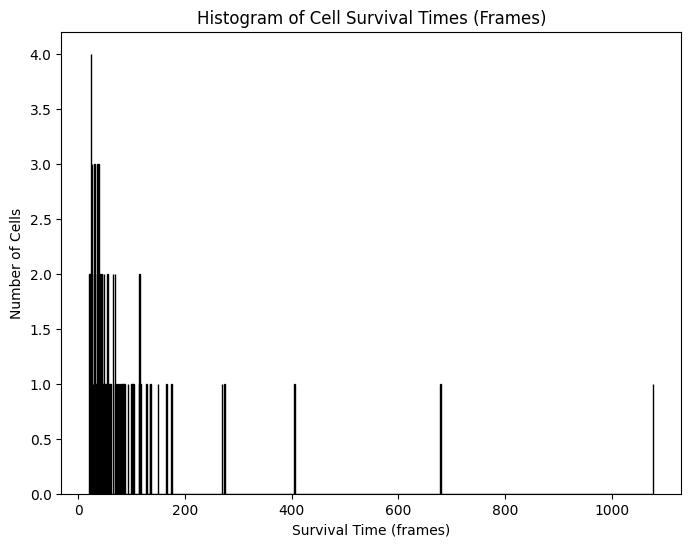

In [19]:
# Option 1: Histogram of survival times in frames 
## This will not work really well for series with differing acquisition frequencies



plt.figure(figsize=(8, 6))
plt.hist(survival_times, bins=range(min(survival_times), max(survival_times)+2), edgecolor='black')
plt.xlabel("Survival Time (frames)")
plt.ylabel("Number of Cells")
plt.title("Histogram of Cell Survival Times (Frames)")
plt.show()

In [ ]:
# Option 1: Histogram of survival times in frames
plt.figure(figsize=(8, 6))
plt.hist(survival_times, bins=20, range = (0, 200), edgecolor='black')
plt.xlim(0, 200)
plt.xlabel("Survival Time (frames)")
plt.ylabel("Number of Cells")
plt.title("Histogram of Cell Survival Times (Frames)")
plt.show()

In [ ]:
# Option 2: Convert survival times to minutes (if FRAME_INTERVAL is defined)
time_per_frame = acquisition_freq    # One minute per frame

survival_times_minutes = [t * time_per_frame for t in survival_times]
plt.figure(figsize=(8, 6))
# Create bins with step size equal to FRAME_INTERVAL
bins = range(min(survival_times_minutes), max(survival_times_minutes) + FRAME_INTERVAL, FRAME_INTERVAL)
plt.hist(survival_times_minutes, bins=bins, edgecolor='black')
plt.xlabel("Survival Time (minutes)")
plt.ylabel("Number of Cells")
plt.title("Histogram of Cell Survival Times (Minutes)")
plt.show()

### Plots for py scripts with save function

In [ ]:
import os
import matplotlib.pyplot as plt

PLOT_DIR = "/home/nbahou/myimaging/apoDet/data/plots"
RUN_NAME = "test"

# Define the output directory
output_dir = os.path.join(PLOT_DIR, RUN_NAME)
os.makedirs(output_dir, exist_ok=True)  # Create directory if it doesn't exist

# Create the plot
plt.figure(figsize=(8, 6))
plt.hist(survival_times, bins=range(min(survival_times), max(survival_times)+2), edgecolor='black')
plt.xlabel("Survival Time (frames)")
plt.ylabel("Number of Cells")
plt.title("Histogram of Cell Survival Times (Frames)")

# Save the plot to a file
plot_filename = os.path.join(output_dir, "survival_times_histogram.png")
plt.savefig(plot_filename)

# Optionally, you can close the plot to free up memory
plt.close()


In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(survival_times, bins=20, range=(0, 200), edgecolor='black')
plt.xlim(0, 200)
plt.xlabel("Survival Time (frames)")
plt.ylabel("Number of Cells")
plt.title("Histogram of Cell Survival Times (Frames)")

# Save the plot to a file
plot_filename = os.path.join(output_dir, "survival_times_histogram_option1.png")
plt.savefig(plot_filename)

# Optionally, display the plot
plt.show()

# Close the plot to free up memory
plt.close()

In [ ]:
# Original code
logger.info("\tStarting cropping for apo cells")
    for i, row in tqdm(apo_annotations.iterrows(), total=len(apo_annotations), desc="Processing Annotations"):
        current_track_id = row.loc['matching_track']
        current_t = row.loc['t'] + row.loc['delta_ts']

        apo_track_ids.loc[i, 'track_id'] = current_track_id
        apo_track_ids.loc[i, 'apo_start_t'] = current_t

        #current_track_id = current_track_id.squeeze()
        if not np.isscalar(current_track_id):
            current_track_id = current_track_id.iloc[0]

        
        single_cell_df = merged_df_long.loc[(merged_df_long['track_id'] == current_track_id) & (merged_df_long['t'] >= current_t)]
        if len(single_cell_df) < num_frames + 1:
            logger.warning(f"\t\tSkipping current track: {current_track_id}. Reason: Track lost too quickly after anno. len = {len(single_cell_df)}")
            continue
        
        # Count track length after manual apoptosis annotation (for histogram later)
        num_entries = single_cell_df.shape[0]
        survival_times.append(num_entries)

        # merged_df_long.loc[single_cell_df.index, 'apoptotic'] = 1
        merged_df_long.loc[(merged_df_long['track_id'] == current_track_id) & (merged_df_long['t'] >= current_t), 'apoptotic'] = 1
        single_cell_df = single_cell_df.loc[single_cell_df['t'] < current_t + num_frames + step]
        
        
        windows = []
        for _, sc_row in single_cell_df.iterrows():
            window = crop_window(imgs[int(sc_row['t'])], int(sc_row['x']), int(sc_row['y']), WINDOW_SIZE)
            if window.shape == (target_size, target_size):    ### This is a bit dangerous! can mess up time if we simply leave a window out
                windows.append(window)
            else:
                windows.append(None)


        chosen_offset = None
        for offset in range(step):
            sub_windows = windows[offset::step]
            if all(x is not None for x in sub_windows):  
                chosen_offset = offset
                break  # Stop as soon as a valid sequence is found

        if chosen_offset is None:
            logger.warning("\t\tNo valid start point for a sequence with correct intervals found.")
        else:
            sub_windows = windows[chosen_offset::step]
            sub_windows = np.asarray(sub_windows)
            if len(sub_windows) == (MAX_TRACKING_DURATION // step) + 1:
                tiff.imwrite(os.path.join(CROPS_DIR, filename, f'trackID_{current_track_id}.tif'), sub_windows)
                tiff.imwrite(os.path.join(WINDOWS_DIR, 'apo', f'apo_{filename}_{i}.tif'), sub_windows)
                num_apo_crops += 1
            else:
                logger.warning(f'\t\tAt least one of the images has the wrong size after cropping and could not be used. Length = {len(windows)}. Pos = {sc_row["x"]}, {sc_row["y"]}.')
    logger.info(f"\t\tValid crops of apo cells found for {num_apo_crops}/{len(apo_annotations)}")

    num_random_tracks = num_apo_crops
    
    logger.info('\tStarting cropping for non-apo cells.')
    # Get crops of healthy cells
    long_no_apo_df = merged_df_long[merged_df_long['apoptotic'] == 0]
    unique_track_ids = np.unique(long_no_apo_df['track_id'])

    num_healthy_crops = 0
    rejected_windows = 0

    for i, track_id in tqdm(enumerate(unique_track_ids), total=len(unique_track_ids), desc="Cropping non-apo Windows"):
        single_cell_df = long_no_apo_df.loc[long_no_apo_df['track_id'] == track_id]
        start_t = min(single_cell_df['t'])
        # same length as for apoptotic cells
        single_cell_df = single_cell_df.loc[single_cell_df['t'] <= start_t + num_frames]
        windows = []
        for _, sc_row in single_cell_df.iterrows():
            window = crop_window(imgs[int(sc_row['t'])], int(sc_row['x']), int(sc_row['y']), WINDOW_SIZE)
            if window.shape == (target_size, target_size):    ### This is a bit dangerous! can mess up time if we simply leave a window out
                windows.append(window)

        if len(windows) == (MAX_TRACKING_DURATION) + 1:
            windows = np.asarray(windows)
            tiff.imwrite(os.path.join(CROPS_DIR, f'no_apo_{filename}', f'trackID_{track_id}.tif'), windows[::step])
            tiff.imwrite(os.path.join(WINDOWS_DIR, 'no_apo', f'no_apo_{filename}_{i}.tif'), windows[::step])
            num_healthy_crops += 1
        else:
            rejected_windows += 1

            logger.debug(f'\t\tAt least one of the images has the wrong size. Length = {len(windows)}. Pos = {sc_row["x"]}, {sc_row["y"]}.')
    logger.info(f"\t\tFound {num_healthy_crops} valid crops of healthy cells.")
    if rejected_windows > 0:
        logger.warning(f"\t\t{rejected_windows} windows were rejected due to incorrect size.")
    
    # Gather random crops 
    ### I think this could be problematic, oftentimes is full of cells so not really background or negative
    logger.info(f'\tStarting cropping for {num_random_tracks} random locations.')

    # Assuming imgs is a list/array of your image frames,
    # and each image has dimensions: img_height x img_width
    img_height, img_width = imgs[0].shape

    iter_count = 0
    crop_count = 0
    while (crop_count <= num_random_tracks) and (iter_count <= 100):    # Iter count only to stop runaway code
    # for track in range(num_random_tracks):
        # Randomly choose a start time such that the track fits in your image sequence
        start_t = np.random.randint(0, len(imgs) - num_frames)
        
        # Randomly generate valid (x, y) coordinates for the crop center
        random_x = np.random.randint(WINDOW_SIZE//2, img_width - WINDOW_SIZE//2)
        random_y = np.random.randint(WINDOW_SIZE//2, img_height - WINDOW_SIZE//2)
        
        windows = []
        # Extract a window for each frame in the track duration
        for t in range(start_t, start_t + num_frames + 1, step):
            window = crop_window(imgs[t], random_x, random_y, WINDOW_SIZE)
            track_id_mask_crop = crop_window(tracked_masks[t], random_x, random_y, WINDOW_SIZE)
            present_track_ids = track_id_mask_crop.flatten().tolist()
            

            ### Continue here
            current_apo_track_ids = apo_track_ids.loc[apo_track_ids['apo_start_t'] <= t]
            current_apo_ids = set(current_apo_track_ids['track_id'])

            
            if not any(pixel in current_apo_ids for pixel in present_track_ids) and (window.shape == (target_size, target_size)):
                windows.append(window)
            else:
                logger.warning("\t\tCurrent window contains an apoptotic cell or the shape is not matching the target size.")

    
        if len(windows) == (MAX_TRACKING_DURATION//FRAME_INTERVAL) + 1:
            windows = np.asarray(windows)
            tiff.imwrite(os.path.join(CROPS_DIR, f'random_{filename}', f'ID_{crop_count}.tif'), windows)
            tiff.imwrite(os.path.join(WINDOWS_DIR, 'random', f'random_{filename}_{crop_count}.tif'), windows)
            crop_count += 1
            iter_count += 1
        else:
            logger.warning(f'\t\tUnable to collect the desired number of images. Length windows = {len(windows)}')
            iter_count += 1

    logger.info(f"Finished processing {filename}: apo ({num_apo_crops}), healthy ({num_healthy_crops}), random ({num_random_tracks})")

In [ ]:
def generate_cell_windows(single_cell_df, imgs, target_size):
    """Generate image windows for a single cell track."""
    windows = []
    for _, sc_row in single_cell_df.iterrows():
        window = crop_window(
            imgs[int(sc_row['t'])],
            int(sc_row['x']),
            int(sc_row['y']),
            WINDOW_SIZE
        )
        windows.append(window if window.shape == (target_size, target_size) else None)
    return windows

def find_valid_sequence_offset(windows, step):
    """Find first valid offset for complete sequence."""
    for offset in range(step):
        sub_windows = windows[offset::step]
        if all(x is not None for x in sub_windows):
            return offset
    return None


def save_valid_sequence(sub_windows, track_id, filename, base_dirs):
    """Save validated window sequence to appropriate directories."""
    try:
        seq_length = len(sub_windows)
        if seq_length == (MAX_TRACKING_DURATION // step) + 1:
            tiff.imwrite(os.path.join(base_dirs['crops'], f'trackID_{track_id}.tif'), sub_windows)
            tiff.imwrite(os.path.join(base_dirs['windows'], f'apo_{filename}_{i}.tif'), sub_windows)
            return True
    except Exception as e:
        logger.error(f"Error saving sequence {track_id}: {str(e)}")
    return False

def process_apo_cell(row, merged_df_long, imgs, target_size, step, num_frames, base_dirs):
    """Process a single apoptotic cell annotation."""
    current_track_id = row['matching_track']
    current_t = row['t'] + row['delta_ts']

    # Track validation
    single_cell_df = merged_df_long[
        (merged_df_long['track_id'] == current_track_id) &
        (merged_df_long['t'] >= current_t)
    ]
    
    if len(single_cell_df) < num_frames + 1:
        return 0, len(single_cell_df)
    
    # Update dataframe
    merged_df_long.loc[
        (merged_df_long['track_id'] == current_track_id) &
        (merged_df_long['t'] >= current_t), 'apoptotic'
    ] = 1
    
    # Window processing
    windows = generate_cell_windows(single_cell_df, imgs, target_size)
    offset = find_valid_sequence_offset(windows, step)
    
    if offset is None:
        return 0, None
    
    # Save valid sequences
    sub_windows = np.asarray(windows[offset::step])
    success = save_valid_sequence(sub_windows, current_track_id, base_dirs)
    
    return (1, len(single_cell_df)) if success else (0, None)

### Modular attempt

In [24]:
from typing import Dict, Any, Tuple

class CropProcessor:
    """Base class for different crop types"""
    
    def __init__(self, config: Dict[str, Any], logger: logging.Logger):
        self.config = config
        self.logger = logger
        self.results = {
            'success': 0,
            'errors': [],
            'warnings': []
        }

    def _create_dirs(self):
        """Ensure output directories exist"""
        os.makedirs(self.config['crops_dir'], exist_ok=True)
        os.makedirs(self.config['windows_dir'], exist_ok=True)

    def _generate_windows(self, positions, imgs):
        """Generate windows from position data"""
        windows = []
        for t, x, y in positions:
            try:
                window = crop_window(imgs[t], x, y, self.config['window_size'])
                if window.shape == (self.config['target_size'], self.config['target_size']):
                    windows.append(window)
                else:
                    windows.append(None)
                    #print(windows.shape)
                    self.logger.warning(f"Invalid window size at ({x}, {y})")
            except Exception as e:
                windows.append(None)
                self.results['errors'].append(str(e))
        return windows

    def _validate_sequence(self, windows, step):
        """Find valid sequence offset"""
        for offset in range(step):
            sub_windows = windows[offset::step]
            if all(x is not None for x in sub_windows):
                return sub_windows
        return None

    
    def _save_sequence(self, windows: np.ndarray, save_path: str, filename: str):
        """Save window sequence"""
        try:
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            tiff.imwrite(save_path, windows)
            self.logger.debug(f"Saved: {os.path.basename(save_path)}")
            return True
        except Exception as e:
            self.logger.error(f"Failed to save {save_path}: {str(e)}")
            return False
    

    def process(self, *args, **kwargs):
        """To be implemented by subclasses"""
        raise NotImplementedError


class ApoptoticProcessor(CropProcessor):
    """Process apoptotic cell sequences"""
    
    def process(self, annotations: pd.DataFrame, merged_df: pd.DataFrame, imgs: np.ndarray):
        self._create_dirs()
        
        for i, row in annotations.iterrows():
            try:
                # Track validation
                track_id = row['matching_track']
                positions = self._get_positions(track_id, row, merged_df)
                
                # Window processing
                windows = self._generate_windows(positions, imgs)
                valid_windows = self._validate_sequence(windows, self.config['step'])
                
                if valid_windows and self._save_sequence(valid_windows, f"apo_{track_id}"):
                    self.results['success'] += 1
                    self._update_tracking_df(merged_df, track_id, row)
                    
            except Exception as e:
                self.results['errors'].append(str(e))
        
        return self.results

    def _get_positions(self, track_id, row, merged_df):
        """Extract positions for apoptotic track"""
        current_t = row['t'] + row['delta_ts']
        mask = (
            (merged_df['track_id'] == track_id) &
            (merged_df['t'] >= current_t) &
            (merged_df['t'] < current_t + self.config['num_frames'] + self.config['step'])
        )
        return merged_df.loc[mask, ['t', 'x', 'y']].values

    def _update_tracking_df(self, merged_df: pd.DataFrame, track_id: int, row: pd.Series):
        """Update the tracking dataframe to mark apoptotic cells."""
        try:
            # Calculate apoptosis start time
            apo_start_t = row['t'] + row['delta_ts']
            
            # Create boolean mask for affected cells
            time_mask = (merged_df['t'] >= apo_start_t)
            track_mask = (merged_df['track_id'] == track_id)
            
            # Update apoptotic status
            merged_df.loc[time_mask & track_mask, 'apoptotic'] = 1
            
            # Optional: Add timestamp metadata
            merged_df.loc[time_mask & track_mask, 'apo_start_t'] = apo_start_t
            
        except KeyError as e:
            self.logger.error(f"Missing column in tracking dataframe: {str(e)}")
        except Exception as e:
            self.logger.error(f"Failed to update tracking DF for track {track_id}: {str(e)}")

class HealthyCellProcessor(CropProcessor):
    """Process healthy cell sequences"""
    
    def process(self, track_ids: list, merged_df: pd.DataFrame, imgs: np.ndarray):
        self._create_dirs()
        
        for track_id in track_ids:
            try:
                positions = self._get_positions(track_id, merged_df)
                windows = self._generate_windows(positions, imgs)
                
                if len(windows) == self.config['required_frames']:
                    if self._save_sequence(windows[::self.config['step']], f"healthy_{track_id}"):
                        self.results['success'] += 1
            except Exception as e:
                self.results['errors'].append(str(e))
        
        return self.results

class RandomLocationProcessor(CropProcessor):
    """Process random background locations"""
    
    def _valid_location(self, positions: list, masks: np.ndarray, apo_track_ids: pd.DataFrame) -> bool:
        """Validate that location doesn't contain apoptotic cells at any timepoint"""
        for t, x, y in positions:
            try:
                # Crop tracking mask at current position
                mask_crop = crop_window(masks[t], x, y, self.config['window_size'])
                present_ids = set(np.unique(mask_crop))
                
                # Get apoptotic tracks active by this timepoint
                active_apo_ids = set(
                    apo_track_ids.loc[
                        apo_track_ids['apo_start_t'] <= t,
                        'track_id'
                    ]
                )
                
                # Check for overlap with apoptotic cells
                if present_ids & active_apo_ids:
                    return False
                    
            except Exception as e:
                self.logger.debug(f"Location validation error: {str(e)}")
                return False
                
        return True

    def process(self, imgs: np.ndarray, masks: np.ndarray, 
                apo_track_ids: pd.DataFrame, num_samples: int) -> dict:
        """Process random locations with enhanced validation"""
        self._create_dirs()
        img_height, img_width = imgs[0].shape
        self.results['attempts'] = 0
        max_attempts = num_samples * 5  # Prevent infinite loops
        
        while (self.results['success'] < num_samples and 
               self.results['attempts'] < max_attempts):
            
            # Generate random position
            x = np.random.randint(
                self.config['window_size']//2, 
                img_width - self.config['window_size']//2
            )
            y = np.random.randint(
                self.config['window_size']//2, 
                img_height - self.config['window_size']//2
            )
            start_t = np.random.randint(0, len(imgs) - self.config['num_frames'])
            
            # Create time sequence
            positions = [
                (t, x, y) 
                for t in range(
                    start_t, 
                    start_t + self.config['num_frames'] + 1, 
                    self.config['step']
                )
            ]
            
            # Validate location
            if not self._valid_location(positions, masks, apo_track_ids):
                self.results['attempts'] += 1
                continue
                
            # Generate and validate windows
            windows = self._generate_windows(positions, imgs)
            valid_windows = self._validate_sequence(windows, self.config['step'])
            
            if valid_windows and self._save_sequence(valid_windows, f"random_{self.results['success']}"):
                self.results['success'] += 1
                
            self.results['attempts'] += 1
            
        return self.results

    

class RandomLocationProcessor(CropProcessor):
    """Process random background locations"""
    
    def process(self, imgs: np.ndarray, masks: np.ndarray, num_samples: int):
        self._create_dirs()
        img_height, img_width = imgs[0].shape
        
        while self.results['success'] < num_samples:
            try:
                x = np.random.randint(self.config['window_size']//2, img_width - self.config['window_size']//2)
                y = np.random.randint(self.config['window_size']//2, img_height - self.config['window_size']//2)
                start_t = np.random.randint(0, len(imgs) - self.config['num_frames'])
                
                positions = [
                    (t, x, y)
                    for t in range(start_t, start_t + self.config['num_frames'] + 1, self.config['step'])
                ]
                
                if self._valid_location(positions, masks):
                    windows = self._generate_windows(positions, imgs)
                    if self._save_sequence(windows, f"random_{self.results['success']}"):
                        self.results['success'] += 1
            except Exception as e:
                self.results['errors'].append(str(e))
        
        return self.results

In [ ]:
    # Configuration setup
    base_config = {
        'window_size': WINDOW_SIZE,
        'target_size': WINDOW_SIZE if WINDOW_SIZE%2 != 0 else WINDOW_SIZE + 1,
        'step': step,
        'num_frames': num_frames,
        'required_frames': (MAX_TRACKING_DURATION // step) + 1
    }
    
    # Process apoptotic cells
    apo_processor = ApoptoticProcessor(
        config={
            **base_config,
            'crops_dir': os.path.join(CROPS_DIR, filename),
            'windows_dir': os.path.join(WINDOWS_DIR, 'apo')
        },
        logger=logger
    )
    apo_results = apo_processor.process(apo_annotations, merged_df_long, imgs)
    


    # Process healthy cells
    healthy_processor = HealthyCellProcessor(
        config={
            **base_config,
            'crops_dir': os.path.join(CROPS_DIR, f'no_apo_{filename}'),
            'windows_dir': os.path.join(WINDOWS_DIR, 'no_apo')
        },
        logger=logger
    )
    healthy_results = healthy_processor.process(unique_track_ids, merged_df_long, imgs)
    
    # Process random locations
    random_processor = RandomLocationProcessor(
        config={
            **base_config,
            'crops_dir': os.path.join(CROPS_DIR, f'random_{filename}'),
            'windows_dir': os.path.join(WINDOWS_DIR, 'random')
        },
        logger=logger
    )
    random_results = random_processor.process(imgs, tracked_masks, num_random_tracks)